In [1]:
import pandas as pd
import requests
from tqdm import tqdm_notebook
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [0]:
data = pd.read_json('tyres.json')

In [3]:
data.head()

,id,name,make,rotationImageUrls,type
0,24,POTENZA RE92,"{'id': '1', 'name': 'BRIDGESTONE'}",[https://media.tirelibrary.com/images/5b33c2e9...,0
1,50,ALL-TERRAIN T/A KO,"{'id': '4', 'name': 'BFGOODRICH'}",[https://tireweb.tirelibrary.com/images/Produc...,0
2,14,POTENZA RE050A,"{'id': '1', 'name': 'BRIDGESTONE'}",[https://tireweb.tirelibrary.com/images/Produc...,0
3,11,POTENZA RE92A,"{'id': '1', 'name': 'BRIDGESTONE'}",[https://tireweb.tirelibrary.com/images/Produc...,0
4,25,POTENZA RE040,"{'id': '1', 'name': 'BRIDGESTONE'}",[https://tireweb.tirelibrary.com/images/Produc...,0


In [0]:
def download_file(url, file_path, progress_bar=False):
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length'))
    if progress_bar: 
        bar = tqdm_notebook(total=total_size, unit='B', unit_scale=True)
        bar.set_description(os.path.split(file_path)[-1])
    incomplete_download = False
    try:
        with open(file_path, 'wb', buffering=16 * 1024 * 1024) as f:
            for chunk in r.iter_content(4 * 1024 * 1024):
                f.write(chunk)
                if progress_bar:
                    bar.update(len(chunk))
    except Exception as e:
        raise e
    finally:
        if progress_bar:
            bar.close()
        if os.path.exists(file_path) and os.path.getsize(file_path) != total_size:
            incomplete_download = True
            os.remove(file_path)
    if incomplete_download:
        raise Exception("Incomplete download")

In [0]:
def decode_image_from_buf(buf):
    img = cv2.imdecode(np.asarray(bytearray(buf), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Посмотрим на имеющиеся изображения

In [0]:
imgs = []
for ix, url in enumerate(data.iloc[3].rotationImageUrls):
    download_file(url, 'imgs/tire_%d.jpg' % (ix))
    img = decode_image_from_buf(open('imgs/tire_%d.jpg' % (ix), 'rb').read())
    imgs.append(img)

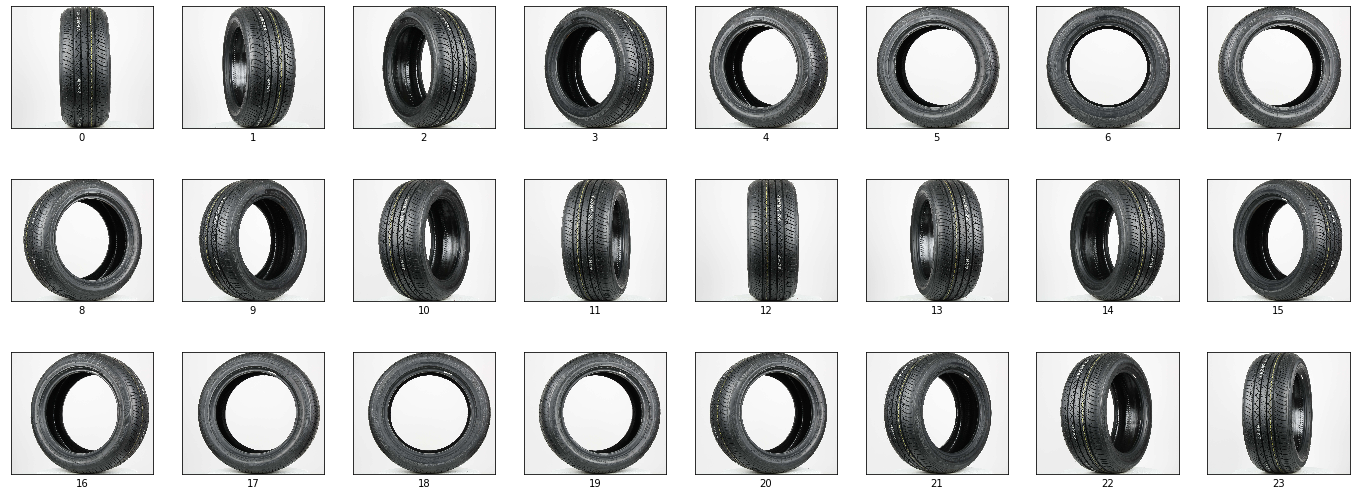

In [155]:
plt.figure(figsize=(24,9))

for i in range(len(imgs)):
    plt.subplot(3,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[i], cmap=plt.cm.binary)
    plt.xlabel(i)
plt.show()

Так как "классифицируемые изображения всегда будут представлять из себя фото выполненные под углом 90гр к плоскоси протектора", приведём данные для обучения к такому же виду. Для этого нам подойдут изображения на которых шина не повёрнута, т.е. 0 и 12. Используем для обучения только изображения с индексом 0 для каждого класса, а с индексом 12 оставим для тестирования

In [0]:
# Т.к. все изображения в обучающей выборке одинакового размера (кроме 0 примера- не будем его рассматривать), 
# то можно взять константный отступ от краёв, чтобы вырезать нужную нам часть из середины
def image_center_crop(img):
    h, w = img.shape[0], img.shape[1]
    pad_top = 864
    pad_bottom = 864
    pad_left = 1080
    pad_right = 1080
    return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]

In [0]:
def crop_and_preprocess(img, input_shape):
    img = image_center_crop(img)  # Вырежем нужную часть
    img = cv2.resize(img, input_shape)  # Приведём к нужному размеру
    img = img.astype("float32")  # Подготовка к нормализации
    img /= 255.0  # Нормализация
    return img

Посмотрим что получается после обработки

In [0]:
def show_image(img, title=None):
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

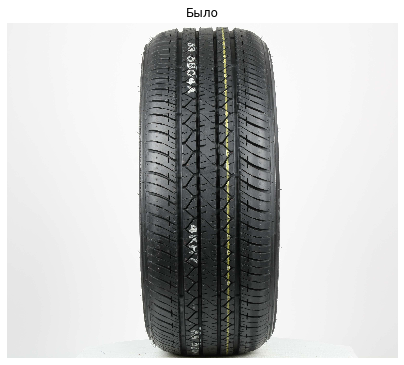

(2592, 3024, 3)


In [156]:
img = decode_image_from_buf(open('imgs/tire_0.jpg', 'rb').read())
show_image(img, 'Было')
print(img.shape)

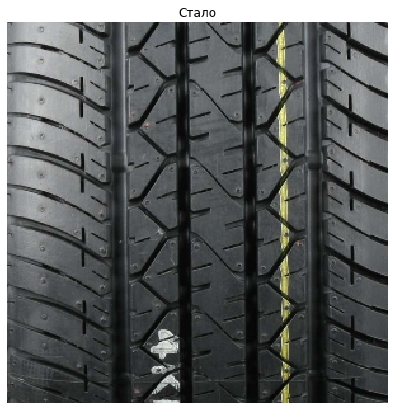

(300, 300, 3)

In [157]:
show_image(crop_and_preprocess(img, (300, 300)), 'Стало')
crop_and_preprocess(img, (300, 300)).shape

In [0]:
# т.к. примеров для каждого класса в обучающей выборке мало, сделаем аугментацию
# будем резать изображение на 9 частей и использовать эти части как дополнительные примеры обучающей выборки
def split_crop(img, input_shape):
    img = image_center_crop(img)
    h, w = img.shape[0], img.shape[1]
    pad_side = w // 3
    pad_height = h // 3

    cut_imgs = []
    for i in range(3):
        for j in range(3):
            cut_img = cv2.resize(img[j*pad_height:(j+1)*pad_height, i*pad_side:(i+1)*pad_side, :], input_shape)
            cut_img = cut_img.astype("float32")
            cut_img /= 255.0
            cut_imgs.append(cut_img)
    return cut_imgs

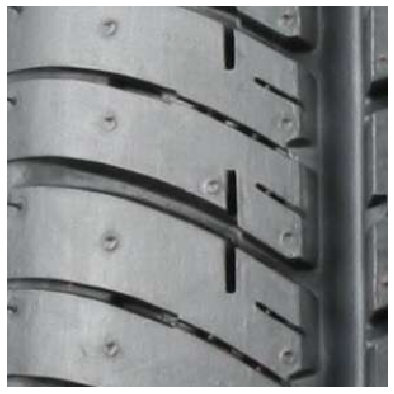

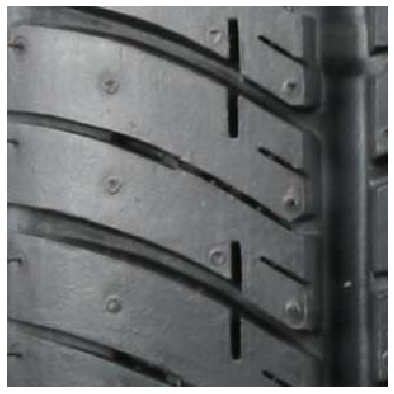

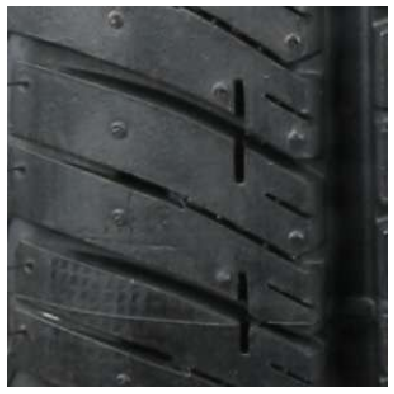

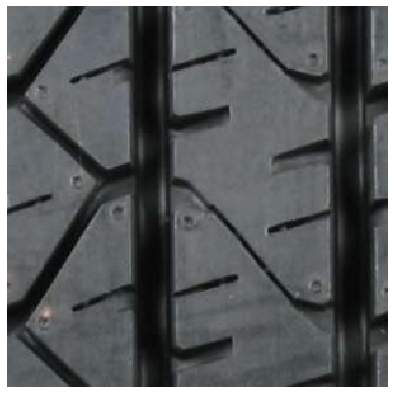

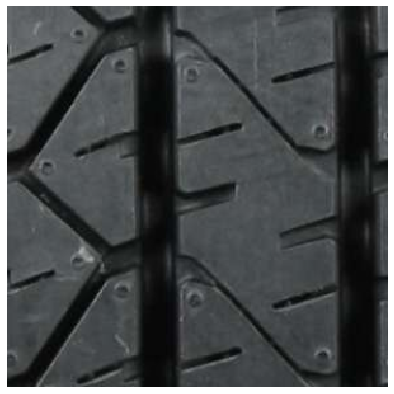

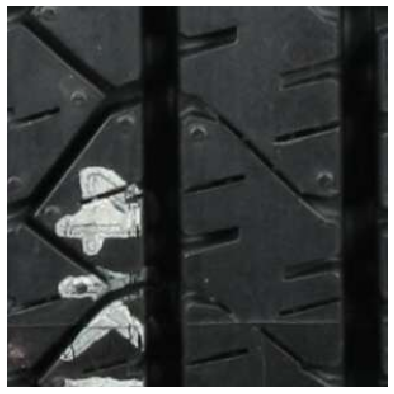

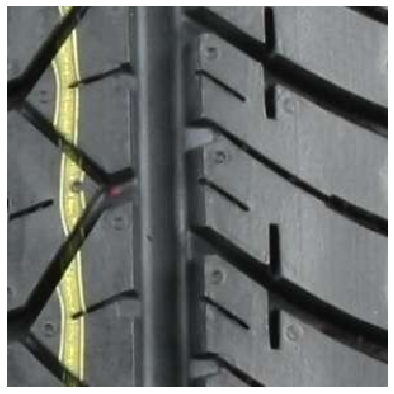

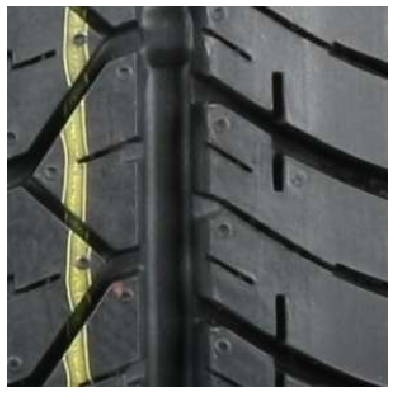

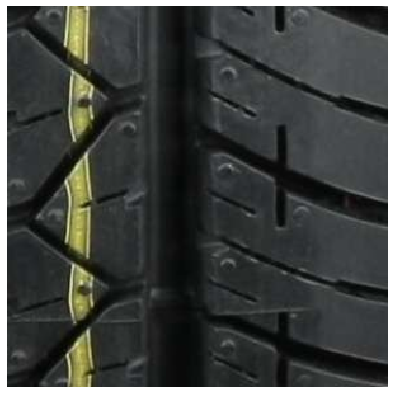

In [166]:
for i in split_crop(img, (300, 300)):
    show_image(i)

Подготовим обучающую выборку. Рассмотрим 100 классов, по 10 изображений на каждый

In [168]:
train_images = []
train_labels = []
id_to_label = dict()
label_to_id = dict()
for ix in tqdm_notebook(range(1, 101)):
    label = data.iloc[ix]['name']
    id_to_label[ix - 1] = label
    label_to_id[label] = ix - 1
    make_name = data.iloc[ix].make['name']
    num = 0
    urls = data.iloc[ix].rotationImageUrls
    for url in [urls[0]]:
        download_file(url, 'imgs/%s_%d_%d.jpg' % (make_name, ix, num))
        img = decode_image_from_buf(open('imgs/%s_%d_%d.jpg' % (make_name, ix, num), 'rb').read())
        num += 1

        train_images.append(crop_and_preprocess(img, (300, 300)))
        train_labels.append(label)

        imgs = split_crop(img, (300, 300))
        train_images.extend(imgs)
        train_labels.extend([label]*len(imgs))

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

In [0]:
# One-hot encoding для таргета
def one_hot_encode(label, mapping):
    encoding = np.zeros(len(mapping))
    encoding[mapping[label]] = 1
    return encoding

In [0]:
target = []
for l in train_labels:
    target.append(one_hot_encode(l, label_to_id))
target = np.asarray(target)

**Модель**

In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras import applications

In [173]:
# Возьмем архитектуру ResNet50 из keras
# weights=None инициализируем модель с рандомными весами
# include_top=False не включаем финальный пулинг и fully connected слой из архитектуры
img_height,img_width = 300, 300
num_classes = 100
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
# Добавим GlobalAveragePooling2D и Dence output слой
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [0]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
model.fit(train_images, target, epochs = 100, batch_size = 32)

Epoch 1/100
1000/1000 [==============================] - 30s 30ms/step - loss: 5.8318 - acc: 0.0160
Epoch 2/100
1000/1000 [==============================] - 12s 12ms/step - loss: 5.2189 - acc: 0.0180
Epoch 3/100
1000/1000 [==============================] - 12s 12ms/step - loss: 4.8844 - acc: 0.0330
Epoch 4/100
1000/1000 [==============================] - 12s 12ms/step - loss: 4.5835 - acc: 0.0360
Epoch 5/100
1000/1000 [==============================] - 12s 12ms/step - loss: 4.4230 - acc: 0.0510
Epoch 6/100
1000/1000 [==============================] - 12s 12ms/step - loss: 4.1608 - acc: 0.0820
Epoch 7/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.8933 - acc: 0.0950
Epoch 8/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.7250 - acc: 0.1240
Epoch 9/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.5509 - acc: 0.1260
Epoch 10/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.3092 - acc: 0.1660

**Test**

Подготовим тестовую выборку

In [185]:
test_images = []
test_labels = []
for ix in tqdm_notebook(range(1, 101)):
    label = data.iloc[ix]['name']
    make_name = data.iloc[ix].make['name']
    num = 0
    urls = data.iloc[ix].rotationImageUrls
    for url in [urls[12]]:
        download_file(url, 'imgs/%s_%d_%d.jpg' % (make_name, ix, num))
        img = decode_image_from_buf(open('imgs/%s_%d_%d.jpg' % (make_name, ix, num), 'rb').read())
        num += 1

        test_images.append(crop_and_preprocess(img, (300, 300)))
        test_labels.append(label)

test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

In [0]:
test_target = []
for l in test_labels:
    test_target.append(one_hot_encode(l, label_to_id))
test_target = np.asarray(test_target)

In [187]:
preds = model.evaluate(test_images, test_target)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

100/100 [==============================] - 0s 5ms/step
Loss = 3.289727668762207
Test Accuracy = 0.38


Найдем несколько примеров тестовых изображений шин из обучающей выбрки в сети

In [0]:
test_dict = {'ALL-TERRAIN T/A KO': 'https://mosautoshina.ru/i/tyre/protector/bf-goodrich-all-terrain-t-a-ko_max.jpg',
             'CROSS TERRAIN SUV': 'https://d2gvvn2873sxv5.cloudfront.net/tYmmRIqYxlX41kVFN8w4Q9fpPAE=/500x/tiregallery/1735/_1739.jpg',
             'G-FORCE T/A KDW': 'https://d2gvvn2873sxv5.cloudfront.net/u7IgAxrm6JO5JWthacNSrURQwU8=/500x/tiregallery/134/_6.jpg',
             'INSIGNIA SE200': 'https://d2gvvn2873sxv5.cloudfront.net/hJWIYiso1DsPdlMHZBs4dqFWq3w=/500x/tiregallery/228/_232.jpg',
             'LATITUDE TOUR HP': 'https://d2gvvn2873sxv5.cloudfront.net/OIX4xfbb-5_rAo3pvg5yZn-tEWQ=/500x/tiregallery/1750/_1758.jpg',
             'LTX M/S': 'https://d2gvvn2873sxv5.cloudfront.net/61n06T4VVQNiNV_k07UVVxNz8c0=/500x/tiregallery/11788/_11796.jpg',
             'PILOT EXALTO A/S': 'https://d2gvvn2873sxv5.cloudfront.net/dtfoK7UX0nNHiB3FaShzLEhZlqs=/500x/tiregallery/1762_new/_michelinpilotexaltoas28.jpg',
             'PILOT MXM4': 'https://d2gvvn2873sxv5.cloudfront.net/Ni8TIyRIZuUzyGhpYDxxCYyneG8=/500x/tiregallery/1766/_1770.jpg',
             'PILOT SPORT': 'https://d2gvvn2873sxv5.cloudfront.net/G45dGPRy6H0vLCWw7zv2ojs_BaI=/500x/tiregallery/7894/_7898.jpg',
             'POTENZA RE040': 'https://d2gvvn2873sxv5.cloudfront.net/B8aZbw6kAv1rq-lrCDtG1YvMuBM=/500x/tiregallery/12316/_4.jpg',
             'POTENZA RE050A': 'https://d2gvvn2873sxv5.cloudfront.net/6fGaKXmsiBVJYlddv8_iTE0va0c=/500x/tiregallery/5961/_5965.jpg',
             'POTENZA RE92A': 'https://d2gvvn2873sxv5.cloudfront.net/yq-43S-Os77WnAzyIy147AdeFbo=/500x/tiregallery/9715/_9721.jpg',
             'RADIAL T/A': 'https://d2gvvn2873sxv5.cloudfront.net/3cMBzGhMcLBTtdu25A5PWVosIo8=/500x/tiregallery/145/_153.jpg',
             'RUGGED TRAIL T/A': 'https://d2gvvn2873sxv5.cloudfront.net/DsH5r9KUebTq6F2p1BP5lMsQ6jk=/500x/tiregallery/149/_159.jpg',
             'TIGER PAW TOURING': 'https://d2gvvn2873sxv5.cloudfront.net/sBbuqwqiba49bpGWsWQxPvGNDpY=/500x/tiregallery/2756/_2776.jpg',
             'TURANZA EL41': 'https://d2gvvn2873sxv5.cloudfront.net/wwpQR7LtqjBrVu17lnkRDb6bf4Q=/500x/tiregallery/269/_271.jpg',
             'TURANZA EL42': 'https://d2gvvn2873sxv5.cloudfront.net/Mw6nR1LUuawApwMfE41H7uP5MCA=/500x/tiregallery/270/_272.jpg',
             'WINTER SLALOM': 'https://d2gvvn2873sxv5.cloudfront.net/2LPoV932B4E---VjAA4mHc6f2UI=/500x/tiregallery/156/_172.jpg',
             'COMMERCIAL T/A ALL-SEASON': 'https://d2gvvn2873sxv5.cloudfront.net/sbGxWANmPvXsarRzIlYKBwin074=/500x/tiregallery/126/_128.jpg',
             'G670 RV MRT': 'https://d2gvvn2873sxv5.cloudfront.net/lWd9rXuiTGS_IE6Cymgaw8Hs4XA=/500x/tiregallery/3112/_17.jpg',
             'EAGLE ULTRA GRIP GW-3': 'https://d2gvvn2873sxv5.cloudfront.net/ueI20xQ4Dd5p14aM4ulGODZeyRE=/500x/tiregallery/11131/_17.jpg',
             'LAREDO CROSS COUNTRY': 'https://d2gvvn2873sxv5.cloudfront.net/817_wJsmsodoePDUL23sGyQNODM=/500x/tiregallery/2742/_18.jpg',
             'LAREDO ALL SEASON AWP': 'https://d2gvvn2873sxv5.cloudfront.net/v3P4GrN14YQd9rTNMpcEuGzF9bE=/500x/tiregallery/2738/_3.jpg',
             'WRANGLER RT/S': 'https://d2gvvn2873sxv5.cloudfront.net/hQBkjEaH7Bu1Y5OsaB4xffIxzBI=/500x/tiregallery/1210/_1214.jpg',
             'PILOT SPORT A/S': 'https://d2gvvn2873sxv5.cloudfront.net/G45dGPRy6H0vLCWw7zv2ojs_BaI=/500x/tiregallery/7894/_7898.jpg'
             }

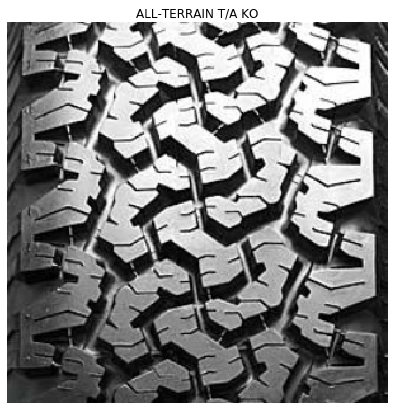

In [189]:
download_file('https://mosautoshina.ru/i/tyre/protector/bf-goodrich-all-terrain-t-a-ko_max.jpg', 'imgs/best_test%d.jpg' % (label_to_id[label]))
img = decode_image_from_buf(open('imgs/best_test%d.jpg' % (label_to_id[label]), 'rb').read())
show_image(preprocess_test(img, (300, 300)), title='ALL-TERRAIN T/A KO')

In [0]:
# тестовые картинки не нужно обрезать, поэтому просто приведём их к нужному размеру и нормализуем
def preprocess_test(img, input_shape):
    img = cv2.resize(img, input_shape)  
    img = img.astype("float32")  
    img /= 255.0  
    return img

In [191]:
test_images = []
test_labels = []
for label, url in tqdm_notebook(test_dict.items()):
    download_file(url, 'imgs/%d_test.jpg' % (label_to_id[label]))
    img = decode_image_from_buf(open('imgs/%d_test.jpg' % (label_to_id[label]), 'rb').read())

    test_images.append(preprocess_test(img, (300, 300)))
    test_labels.append(label)

test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

In [0]:
test_target = []
for l in test_labels:
    test_target.append(one_hot_encode(l, label_to_id))
test_target = np.asarray(test_target)

In [193]:
preds = model.evaluate(test_images, test_target)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

25/25 [==============================] - 0s 5ms/step
Loss = 12.36254596710205
Test Accuracy = 0.03999999910593033


Качество оставляет желать лучшего

In [57]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________